In [1]:
SEED = 47
import numpy as np
np.random.seed(SEED)
import random
random.seed(SEED)
import math
import h5py
import tensorflow as tf
import keras
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.models import Model
from tensorflow.keras.models import load_model
from keras.layers import Dense, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, Concatenate
from keras.layers import Input
from keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard,ReduceLROnPlateau
import numpy as np
# from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from keras.models import load_model

DATA_PATH = r"D:\PBL5\fall-detection-via-camera\fdd.hdf5" # Change dataset path here
WEIGHTS_PATH = r"D:\PBL5\fall-detection-via-camera\weights.hdf5" # Change weight path here

In [2]:
def create_base_model(prefix = None, image_size = 224):
    base_model = MobileNetV2(
        input_shape = (image_size, image_size, 3), alpha = 1.0,
        include_top = False, weights = "imagenet"
    )
    base_model.summary()
    # Prefix all layers' names to avoid conflict
    if prefix != None:
        for layer in base_model.layers:
            layer.name = prefix + "_" + layer.name

    # Freeze base model's layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add top FC layers
    out = base_model.output
    out = GlobalAveragePooling2D()(out)
    out = Dense(256)(out)
    out = BatchNormalization()(out)
    out = Activation("relu")(out)
    out = Dropout(0.5)(out)

    return base_model,out

In [3]:
def create_model(weights_path = None, image_size = 224, show_summary = False):
    spatial_stream, spatial_output = create_base_model(prefix = "spatial", image_size = image_size)
    temporal_stream, temporal_output = create_base_model(prefix = "temporal", image_size = image_size)
    out = Concatenate()([spatial_output, temporal_output])

    out = Dense(128)(out)
    out = BatchNormalization()(out)
    out = Activation("relu")(out)
    out = Dropout(0.5)(out)

    out = Dense(128)(out)
    out = BatchNormalization()(out)
    out = Activation("relu")(out)
    out = Dropout(0.5)(out)

    out = Dense(128)(out)
    out = BatchNormalization()(out)
    out = Activation("relu")(out)
    out = Dropout(0.5)(out)
    
    predictions = Dense(2, activation = "sigmoid")(out)
    model = Model(inputs = [spatial_stream.input, temporal_stream.input], outputs = predictions)

    if weights_path != None:
        model.load_weights(weights_path)
    if show_summary:
        model.summary()
    return model

In [4]:
model = create_model()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [5]:
# # Tune hyperparameters here
# EPOCHS = 100
# LEARNING_RATE = 0.01
# DECAY = 0.001
# MOMENTUM = 0.95
# BATCH_SIZE = 48

# Tune hyperparameters here
EPOCHS = 400
LEARNING_RATE = 0.0001
DECAY = 1e-7
MOMENTUM = 0.95
BATCH_SIZE = 64

# Load data
with h5py.File(DATA_PATH, 'r') as data:
    X_rgb_train = np.array(data['data']['rgb']['train'])
    X_mhi_train = np.array(data['data']['mhi']['train'])
    y_train = np.array(data['labels']['train'])
    X_rgb_val = np.array(data['data']['rgb']['val'])
    X_mhi_val = np.array(data['data']['mhi']['val'])
    y_val = np.array(data['labels']['val'])

In [6]:
def normalize_data(X):
    X = X.astype('float32')
    X /= 255.0
    return X

X_rgb_train = normalize_data(X_rgb_train)
X_mhi_train = normalize_data(X_mhi_train)
X_rgb_val = normalize_data(X_rgb_val)
X_mhi_val = normalize_data(X_mhi_val)

In [7]:
num_classes = np.max(y_train) + 1
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)

In [8]:
X_rgb_train 

array([[[[0.5294118 , 0.52156866, 0.4745098 ],
         [0.5254902 , 0.5176471 , 0.47058824],
         [0.52156866, 0.5137255 , 0.46666667],
         ...,
         [0.20784314, 0.16862746, 0.12156863],
         [0.23921569, 0.2       , 0.16078432],
         [0.2509804 , 0.21176471, 0.17254902]],

        [[0.5254902 , 0.5176471 , 0.47058824],
         [0.5254902 , 0.5176471 , 0.47058824],
         [0.52156866, 0.5137255 , 0.46666667],
         ...,
         [0.19607843, 0.15686275, 0.10980392],
         [0.22352941, 0.18431373, 0.14509805],
         [0.23529412, 0.19607843, 0.15686275]],

        [[0.52156866, 0.50980395, 0.4745098 ],
         [0.52156866, 0.50980395, 0.4745098 ],
         [0.52156866, 0.5137255 , 0.46666667],
         ...,
         [0.16862746, 0.12941177, 0.09019608],
         [0.1764706 , 0.13725491, 0.09803922],
         [0.1764706 , 0.13725491, 0.09803922]],

        ...,

        [[0.27058825, 0.20392157, 0.09411765],
         [0.27058825, 0.20392157, 0.09411765]

In [9]:
y_train

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [10]:
# OUTPUT_PATH = r'D:\PBL5\fall-detection-via-camera\newFDD.hdf5'

# with h5py.File(OUTPUT_PATH, 'w') as data:
#     data.create_dataset('data/rgb/train', data=X_rgb_train)
#     data.create_dataset('data/mhi/train', data=X_mhi_train)
#     data.create_dataset('labels/train', data=y_train)
#     data.create_dataset('data/rgb/val', data=X_rgb_val)
#     data.create_dataset('data/mhi/val', data=X_mhi_val)
#     data.create_dataset('labels/val', data=y_val)

In [11]:
SEED = 42
BATCH_SIZE = 32

def create_two_inputs_gen(X1, X2, labels, batch_size=BATCH_SIZE, shuffle=True):
    gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
    X1_gen = gen.flow(X1, labels, seed=SEED, batch_size=batch_size, shuffle=shuffle)
    X2_gen = gen.flow(X2, seed=SEED, batch_size=batch_size, shuffle=shuffle)

    def generator():
        while True:
            X1_batch, labels_batch = next(X1_gen)
            X2_batch = next(X2_gen)
            yield (X1_batch, X2_batch), labels_batch

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            (tf.TensorSpec(shape=(None, *X1.shape[1:]), dtype=tf.float32),
             tf.TensorSpec(shape=(None, *X2.shape[1:]), dtype=tf.float32)),
            tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32)
        )
    )

    return dataset

In [12]:
train_dataset = create_two_inputs_gen(X_rgb_train,X_mhi_train,y_train)
val_dataset = create_two_inputs_gen(X_rgb_val,X_mhi_val,y_val)

In [13]:
# Initialize callbacks
checkpointer = ModelCheckpoint(
    filepath="D:\PBL5\fall-detection-via-camera\weights\weights.keras", monitor="val_accuracy",
    verbose=1, save_best_only=True
)
early_stopper = EarlyStopping(
    monitor="val_accuracy", min_delta=0.0001, patience=50, verbose=1, mode='max'
)
tensorboard = TensorBoard(log_dir="logs/", write_graph=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=20, verbose=1, min_lr=1e-7
)

# Create optimizer and compile model
optimizer = SGD(learning_rate=LEARNING_RATE, decay=DECAY, momentum=MOMENTUM, nesterov=True)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Fit model
history = model.fit(
   train_dataset,
   epochs=EPOCHS,
   validation_data=val_dataset,
   verbose=1,
   callbacks=[checkpointer, early_stopper, tensorboard, lr_scheduler],
   batch_size=BATCH_SIZE,
   shuffle=True
)


d:\PBL5\fall-detection-via-camera\my_venv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/400
    220/Unknown 620s 3s/step - accuracy: 0.5065 - loss: 0.8583

In [ ]:
import matplotlib.pyplot as plt
def plot_history(history):
    # Accuracy Visualization
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

In [ ]:
import h5py
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import math

def evaluate_model(model=None, validation=False):
    if model is None:
        print("Error: No model specified!")
        return

    # Load data
    data = h5py.File(DATA_PATH, "r")
    target = "val" if validation else "test"
    X_rgb_target = np.array(data["data"]["rgb"][target], dtype=np.float32)
    X_mhi_target = np.array(data["data"]["mhi"][target], dtype=np.float32)
    y_target = np.array(data["labels"][target])

    # Initialize data generator
    BATCH_SIZE = 32
    data_gen = create_two_inputs_gen(X_rgb_target, X_mhi_target, y_target, batch_size=BATCH_SIZE, shuffle=False)

    # Predict and calculate metrics
    steps = math.ceil(len(y_target) / BATCH_SIZE)
    predictions_probs = model.predict(data_gen, steps=steps, verbose=1)

    # Check if predictions_probs need argmax
    if predictions_probs.ndim > 1 and predictions_probs.shape[1] > 1:
        predictions = np.argmax(predictions_probs, axis=1)
    else:
        predictions = np.round(predictions_probs).astype(int).flatten()

    if y_target.ndim > 1 and y_target.shape[1] > 1:
        y_target = np.argmax(y_target, axis=1)
    else:
        y_target = y_target.flatten()

    # Calculate metrics
    loss, accuracy = model.evaluate(data_gen, steps=steps, verbose=0)
    precision = precision_score(y_target, predictions, average='weighted')
    recall = recall_score(y_target, predictions, average='weighted')
    f1 = f1_score(y_target, predictions, average='weighted')

    data.close()

    return {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }


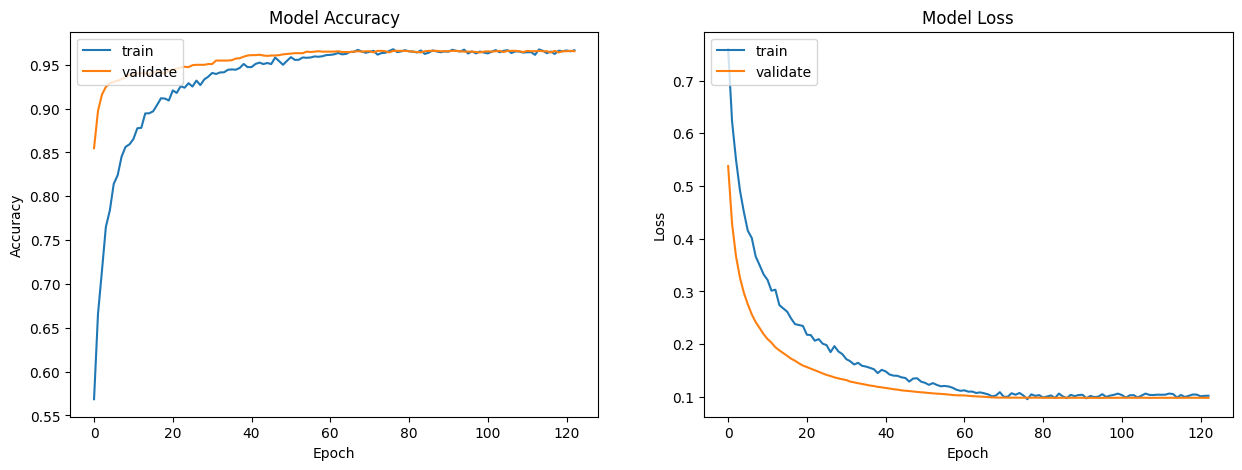

In [ ]:
plot_history(history)

In [ ]:
model.save("/content/drive/MyDrive/hdf5/models.hdf5")

NameError: name 'model' is not defined

In [ ]:
save_model=load_model("/content/drive/MyDrive/hdf5/models.hdf5")

In [ ]:
print(evaluate_model(create_model(WEIGHTS_PATH)))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

40/40 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step


ValueError: You must call `compile()` before using the model.

In [ ]:
evaluate_model(save_model)